In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit


In [2]:
# random seed
np.random.seed(1145142)

## Fitting results

In [3]:
'''
30%
d = 64.6432 +- 3.3425
sigma_k = 0.6726% +- 0.1121%
kappa = 3.7827 +- 0.6305
alpha = 0.7027 +- 0.1171
f_AOT = 24.1135% +- 3.6500%


40%
d = 48.9493 +- 2.0980
sigma_k = 0.7797% +- 0.1299%
kappa = 2.6546 +- 0.4424
alpha = 0.4926 +- 0.0821
f_AOT = 31.1141% +- 2.9012%


50%
d = 38.9151 +- 1.7524
sigma_k = 0.2560% +- 0.0427%
kappa = 1.6590 +- 0.2765
alpha = 0.2992 +- 0.0499
f_AOT = 38.2404% +- 1.9021%
'''
wt_list = [30,40,50]
d_list = [64.6432,48.9493,38.9151]
sigma_k_list = [0.6726e-2, 0.7797e-2, 0.2560e-2]
kappa_list = [3.7827, 2.6546, 1.6590]
alpha_list = [0.7027, 0.4926, 0.2992]

## Define function: Orientation correlation


In [4]:
from Vortex import *

In [5]:
## Generate random wave
def gen_vertex_lines(r_grid, sigma_k, kappa, alpha, d, box_size, x_scale=1, n_grid_scale=128):
    #### Wave vector distribution ####
    scale = box_size/d/2 # how many layers in the box
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    ### generate randomwave
    rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

    scale_zoom = n_grid_scale/rho.shape[0]

    rho, r_grid = scale_rho(rho, r_grid, scale_zoom)

    rho_real = rho.real
    rho_imag = rho.imag
    rho_phase = np.angle(rho)

    vortex_volume = vortex_phase(rho_phase)

    ### Trace defect lines
    array = vortex_volume
    positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
    poslist_arr = np.array(positions_tuple_list)

    sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)
    sample_ordered = get_ordered_points(sample, sample_adj_list)

    sample_ordered_sm = []
    tangent_list = []
    for line in sample_ordered:
        if len(line) == 0:
            continue
        if len(line)>5:
            x = np.arange(len(line))
            x_fine = np.arange(len(line)*x_scale)/x_scale
            arr_line = np.array(line)
            ll = len(line)
            spl_list = [splrep(x,arr_line[:,i],w=np.ones(len(line)),s=ll+np.sqrt(ll*2)) for i in range(3)]
            line_sm = np.array([splev(x_fine,spl) for spl in spl_list]).T
            sample_ordered_sm.append(line_sm)

            # get line tangent
            tangent = np.array(get_tangent(line_sm))
            tangent_list.append(tangent)

        # else:
        #     sample_ordered_sm.append(line)
    print('Finished generating sample lines')
    return r_grid, rho_real, vortex_volume, sample_ordered_sm, tangent_list


In [6]:
def orien_corr(points, tangents, bounds, rr=[], pbc=[0, 0, 0], be=False, line=False):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
                point coordinates, N by 3 array

        tangents: array
                segment tangents, N by 3 array

        bounds: list
                box bounds

        rr: array
            pair distances

        pbc: list
             periodic boundary condition
    """
    N = points.shape[0]
    print(points.shape)
    max_r = np.max(rr)
    nr = len(rr)
    dr = rr[1] - rr[0]

    d_cell = [
        (bounds[0][1] - bounds[0][0]),
        (bounds[1][1] - bounds[1][0]),
        (bounds[2][1] - bounds[2][0])
    ]

    V = d_cell[0] * d_cell[1] * d_cell[2]

    #### handling with finite size effect ####
    index_in = np.arange(N)
    N_in = N
    
    if be:
        index_in_0 = (points[:, 0] >= bounds[0][0]) * (points[:, 0] < bounds[0][1])
        index_in_1 = (points[:, 1] >= bounds[1][0]) * (points[:, 1] < bounds[1][1])
        index_in_2 = (points[:, 2] >= bounds[2][0]) * (points[:, 2] < bounds[2][1])
        index_in = index_in_0 * index_in_1 * index_in_2
        N_in = np.sum(index_in)
        index_in = np.where(index_in)[0]  # transform to coordinate of True's

    rho = N_in / V

    #### two-point correlation ####
    index_d_jk = []
    cos_jk = []
    for i in tqdm(index_in):
        r_ik = points - points[i].reshape(1, 3)
        # for i_3 in range(3):
        #     r_ik[:, i_3] = r_ik[:, i_3] - np.floor(r_ik[:, i_3] / d_cell[i_3]) * d_cell[i_3] * pbc[i_3]  # PBC
        r_ik -= np.floor(r_ik / d_cell) * d_cell * pbc
        d_ik = np.sqrt(np.sum(r_ik ** 2, axis=1))  # pair distances

        # cosine
        cos_ik = np.dot(tangents, tangents[i])

        d_ik_list = d_ik[d_ik != 0]  # pair distances, self exclusive
        cos_ik = cos_ik[d_ik != 0]
        index_d_ik = np.floor(d_ik_list / dr).astype(int)
        index_d_jk.extend(index_d_ik)
        cos_jk.extend(cos_ik)

    index_d_jk = np.array(index_d_jk)

    cos_jk = np.array(cos_jk)
    cos_jk = cos_jk[index_d_jk < nr]

    index_d_jk = index_d_jk[index_d_jk < nr]

    time_start = time()
    #### correlation ####
    n_r = np.zeros(int(nr))
    c_r_sum = np.zeros(int(nr))
    
    np.add.at(c_r_sum, index_d_jk, cos_jk ** 2)
    np.add.at(n_r, index_d_jk, 1)

    c_r = (3 * c_r_sum - n_r) / (2 * n_r)

    # c_r = np.zeros(int(nr))
    # cos2_jk = cos_jk ** 2
    # for index, cos2_pair in tqdm(zip(index_d_jk, cos2_jk), total=len(index_d_jk)):
    #     c_r_sum[index] += cos2_pair
    #     n_r[index] += 1

    # # normalization
    # for ir in range(int(nr)):
    #     c_r[ir] = c_r_sum[ir] / n_r[ir]

    # c_r = (3 * c_r - 1) / 2
    
    time_end = time()
    print('Time used for binning = {}'.format(time_end-time_start))

    return c_r

In [7]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]
box_size = 500
bounds = [[-150,150], [-150,150], [-150,150]]


In [8]:

## Generate random wave
n_grid = 100
n_grid_scale = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cr_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    r_grid, rho_real, vortex_volume, sample_ordered_list, tangent_list = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=6, n_grid_scale = 128)
    sample_all = np.vstack(sample_ordered_list)
    tangent_all = np.vstack(tangent_list)
    points = sample_all/n_grid_scale*box_size-box_size/2

    cr = orien_corr(points, tangent_all, bounds, rr=rr, pbc=[0,0,0], be=True)
    cr_list.append(cr)


Finished generating sample lines
(25050, 3)


100%|██████████| 6087/6087 [00:17<00:00, 340.30it/s]


Time used for binning = 0.636127233505249
Finished generating sample lines
(41184, 3)


100%|██████████| 9137/9137 [00:56<00:00, 161.28it/s]


Time used for binning = 1.5100438594818115
Finished generating sample lines
(56376, 3)


100%|██████████| 13768/13768 [02:16<00:00, 100.85it/s]


Time used for binning = 3.5160202980041504


Text(0, 0.5, '$c(r)$')

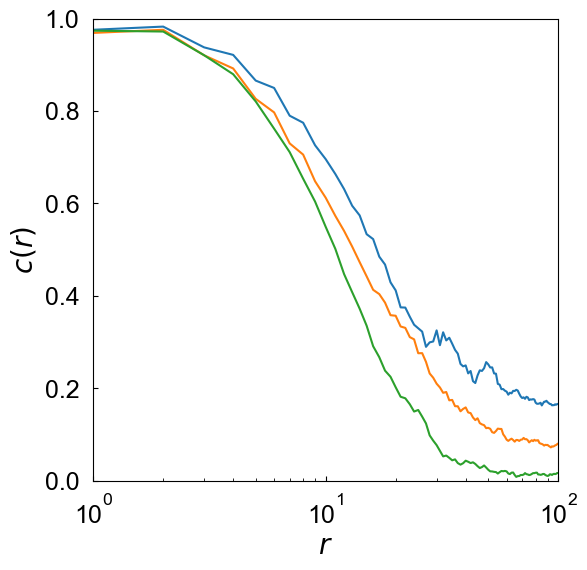

In [9]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    ax.plot(rr, cr_list[i], '-')

ax.set_xlim([1,100])
ax.set_ylim([0,1])
# ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$c(r)$', fontsize=20)

## Define function: Intra-chain OCF


In [20]:
def orien_corr_intra(points, tangents, rr, box_size, n_grid_scale, pbc=[0, 0, 0]):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
            point coordinates, N by 3 array

        tangents: array
            segment tangents, N by 3 array

        rr: array
            pair distances

        pbc: list
            periodic boundary condition
    """
    n_bins = len(rr)
    n_r = np.zeros(n_bins)
    cos_sum_r = np.zeros(n_bins)
    dr = rr[1] - rr[0]
    max_r = np.max(rr)

    for pt, tg in tqdm(zip(points, tangents), total=len(points)):
        # Compute distances between consecutive points
        da = np.diff(pt, axis=0)
        dl = np.sqrt(np.sum(da ** 2, axis=1))

        # Accumulate correlation for each point
        for i in range(len(dl)):
            dl_ij = 0
            for j in range(i, len(dl)):
                dl_ij += dl[j]
                if dl_ij > max_r:
                    break
                cos_ij = np.dot(tg[i], tg[j + 1])
                index_dl_ij = np.floor(dl_ij / dr).astype(int)
                n_r[index_dl_ij] += 1
                cos_sum_r[index_dl_ij] += cos_ij

    # Compute correlation
    c_r = cos_sum_r / n_r
    c_r[np.isnan(c_r)] = 0  # Handle division by zero

    return c_r

In [31]:
ss = (np.arange(300)+1)
box_size = 480
## Generate random wave
n_grid = 150
n_grid_scale = 300
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cr_intra_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    r_grid, rho_real, vortex_volume, sample_ordered_list, tangent_list = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=4, n_grid_scale = n_grid_scale)
    
    c_r = orien_corr_intra(sample_ordered_list, tangent_list, ss, box_size, n_grid_scale, pbc=[0,0,0])
    cr_intra_list.append(c_r)


Finished generating sample lines


100%|██████████| 211/211 [00:34<00:00,  6.04it/s]


Finished generating sample lines


100%|██████████| 543/543 [01:00<00:00,  8.98it/s]


Finished generating sample lines


100%|██████████| 1439/1439 [01:39<00:00, 14.44it/s]


Text(0, 0.5, '$\\left\\langle\\cos\\Theta(s)\\right\\rangle$')

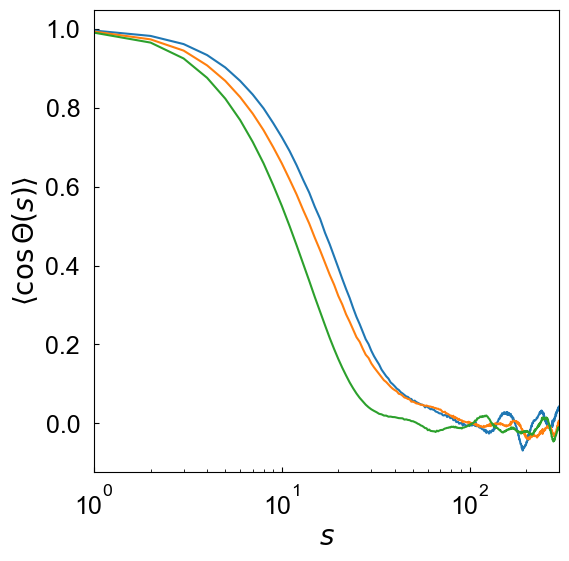

In [32]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    ax.plot(ss, cr_intra_list[i], '-')

ax.set_xlim([1,300])
# ax.set_ylim([1e-2,1])
# ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$s$', fontsize=20)
ax.set_ylabel(r'$\left\langle\cos\Theta(s)\right\rangle$', fontsize=20)

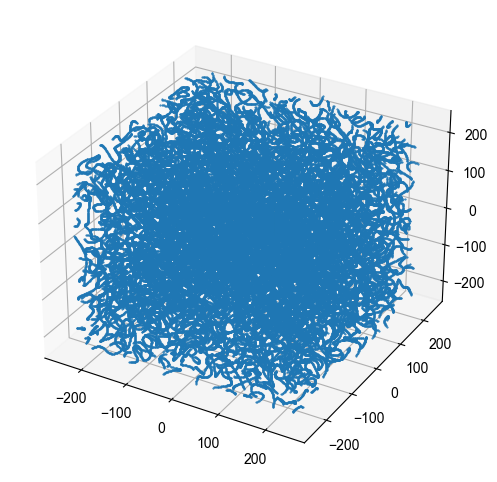

In [33]:
sample_all = np.vstack(sample_ordered_list)
points = sample_all/n_grid_scale*box_size-box_size/2

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1,projection='3d')

ax.plot(points[:,0],points[:,1],points[:,2],'.', ms=1)

# ax.set_xlim([-150,150])
# ax.set_ylim([-150,150])
# ax.set_zlim([-150,150])

## Save results to mat file

In [34]:
mdic = {'cr_list':cr_list, 'cr_intra_list':cr_intra_list, 'rr':rr}
filename = './mat/results_ocf.mat'

savemat(filename,mdic)